In [2]:
# Notebook 2 — Model Training for Energy Prediction

# This notebook performs Phase 2 of the project SRS:
# - Loads the cleaned dataset created in Notebook 1  
# - Creates the target variable: Energy consumption in MWh  
# - Selects numerical features for prediction  
# - Trains multiple regression models  
# - Evaluates using MAE, RMSE, and R²  
# - Saves the best model for deployment  

                 

In [3]:
import pandas as pd
import numpy as np

DATA = "../data/processed/merged_cleaned.csv"
df = pd.read_csv(DATA, parse_dates=["STARTTIME_first"])

print("Dataset loaded:", df.shape)
df.head()


Dataset loaded: (20813, 13)


,HEATID,TAP_first,STARTTIME_first,DURATION_SEC,MW_mean,TEMP_mean,TEMP_p95,VALO2_mean,VALO2_p95,O2_AMOUNT_sum,GAS_AMOUNT_sum,O2_FLOW_mean,GAS_FLOW_mean
0,5F0002,14,2015-01-01 01:12:00,60600.0,6.078125,1627.0,1648.3,383.000000,400.7,428122.0,175048.0,3963.962264,1527.245283
1,5F0003,11,2015-01-01 01:41:00,120600.0,6.078125,1641.0,1651.8,683.000000,696.5,382714.0,156025.0,3771.399194,1556.326613
2,5F0004,11,2015-01-01 02:26:00,123600.0,3.644231,1636.0,1636.0,700.000000,700.0,606453.0,251531.0,3139.359882,1206.572271
3,5F0005,11,2015-01-01 03:27:00,128460.0,4.477273,1630.0,1639.7,625.333333,663.6,453178.0,179407.0,4009.954887,1532.003759
4,5F0006,11,2015-01-01 04:16:00,126000.0,4.534091,1622.0,1644.8,654.600000,756.0,460713.0,178593.0,3881.255556,1504.070370


In [4]:
df["duration_hours"] = df["DURATION_SEC"] / 3600
df = df[df["duration_hours"] > 0]
df["Energy_MWh"] = df["MW_mean"] * df["duration_hours"]

print("Target column created")
df[["HEATID", "MW_mean", "duration_hours", "Energy_MWh"]].head()


Target column created


,HEATID,MW_mean,duration_hours,Energy_MWh
0,5F0002,6.078125,16.833333,102.315104
1,5F0003,6.078125,33.500000,203.617188
2,5F0004,3.644231,34.333333,125.118590
3,5F0005,4.477273,35.683333,159.764015
4,5F0006,4.534091,35.000000,158.693182


In [5]:
num_features = [
    "MW_mean",
    "duration_hours",
    "O2_AMOUNT_sum",
    "GAS_AMOUNT_sum",
    "O2_FLOW_mean",
    "GAS_FLOW_mean",
    "TEMP_mean",
    "TEMP_p95",
    "VALO2_mean",
    "VALO2_p95"
]

num_features = [c for c in num_features if c in df.columns]

X = df[num_features]
y = df["Energy_MWh"]

print("X shape:", X.shape)
print("y shape:", y.shape)
X.head()


X shape: (20813, 10)
y shape: (20813,)


,MW_mean,duration_hours,O2_AMOUNT_sum,GAS_AMOUNT_sum,O2_FLOW_mean,GAS_FLOW_mean,TEMP_mean,TEMP_p95,VALO2_mean,VALO2_p95
0,6.078125,16.833333,428122.0,175048.0,3963.962264,1527.245283,1627.0,1648.3,383.000000,400.7
1,6.078125,33.500000,382714.0,156025.0,3771.399194,1556.326613,1641.0,1651.8,683.000000,696.5
2,3.644231,34.333333,606453.0,251531.0,3139.359882,1206.572271,1636.0,1636.0,700.000000,700.0
3,4.477273,35.683333,453178.0,179407.0,4009.954887,1532.003759,1630.0,1639.7,625.333333,663.6
4,4.534091,35.000000,460713.0,178593.0,3881.255556,1504.070370,1622.0,1644.8,654.600000,756.0


In [6]:
split_index = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print("Train:", X_train.shape)
print("Test :", X_test.shape)


Train: (16650, 10)
Test : (4163, 10)


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_features)
])

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=400, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

results = {}


In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

for name, model in models.items():
    pipe = Pipeline([("pre", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}

results


{'LinearRegression': {'MAE': 10.819728874167,
  'RMSE': np.float64(20.341032862293698),
  'R2': 0.8298447726655308},
 'RandomForest': {'MAE': 0.8727518836376749,
  'RMSE': np.float64(4.379576721158935),
  'R2': 0.9921120605153662},
 'GradientBoosting': {'MAE': 1.5749601128975395,
  'RMSE': np.float64(3.860058546876325),
  'R2': 0.9938724470000236}}

In [9]:
len(X_train), len(X_test), len(df)


(16650, 4163, 20813)

In [10]:
# Saving the best model (GradientBoostingRegressor)
import joblib

best_model = Pipeline([
    ("pre", preprocess),
    ("model", GradientBoostingRegressor(random_state=42))
])

# Train on full training set before saving
best_model.fit(X_train, y_train)

# Save model as .pkl file for later use or deployment
joblib.dump(best_model, "../models/energy_model_gb.pkl")

print("Model saved to ../models/energy_model_gb.pkl")


Model saved to ../models/energy_model_gb.pkl


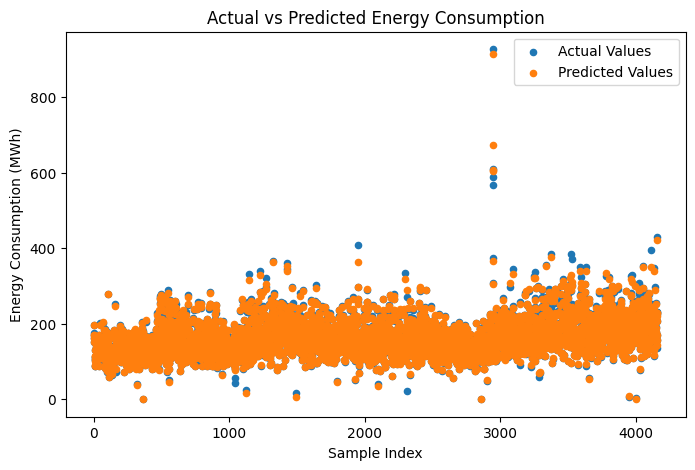

In [11]:
# Plotting actual vs predicted energy consumption values
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test)

plt.figure(figsize=(8,5))
plt.scatter(range(len(y_test)), y_test, label="Actual Values", s=20)
plt.scatter(range(len(y_test)), y_pred, label="Predicted Values", s=20)
plt.xlabel("Sample Index")
plt.ylabel("Energy Consumption (MWh)")
plt.title("Actual vs Predicted Energy Consumption")
plt.legend()
plt.show()


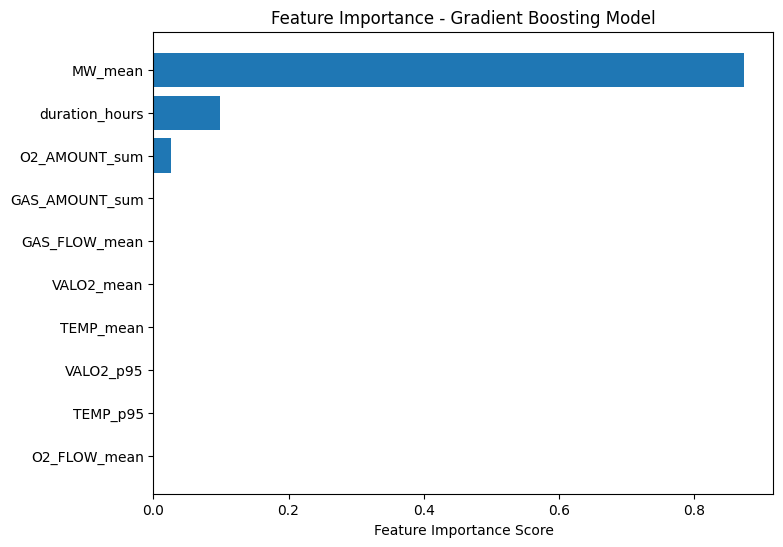

In [12]:
# Plotting feature importance for GradientBoosting model
import numpy as np

model = best_model.named_steps["model"]
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), np.array(num_features)[indices])
plt.xlabel("Feature Importance Score")
plt.title("Feature Importance - Gradient Boosting Model")
plt.show()


In [14]:
# Export actual vs predicted values to CSV for further analysis or reporting
import os
os.makedirs("../outputs", exist_ok=True)

pred_df = pd.DataFrame({
    "HEATID": df.iloc[split_index:]["HEATID"],
    "Actual_MWh": y_test,
    "Predicted_MWh": y_pred
})

pred_df.to_csv("../outputs/predictions.csv", index=False)
print("Predictions exported to ../outputs/predictions.csv")
pred_df.head()


Predictions exported to ../outputs/predictions.csv


,HEATID,Actual_MWh,Predicted_MWh
16650,7F6118,195.911111,194.961273
16651,7F6119,161.603526,162.572368
16652,7F6120,173.612500,170.884948
16653,7F6121,168.545238,168.540165
16654,7F6122,151.946667,151.936263
